In [25]:
"""To use this notebook you'll need to clone the landcover repo from https://github.com/microsoft/landcover
and create the python env described in the readme. To run this notebook as-is, you'll also have to download 
data following the instructions there and move that data to qr_for_landcover/evaluation/data. """

#import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import os
import torch
import rasterio
#import gdal
import sys
sys.path.append('../../landcover')
from web_tool.DataLoader import DataLoaderLCLayer


# #sys.path.append('../../lc-mapping/scripts')

# import img_util
import shapely
# import nn_functions as nn

# import matplotlib
# import matplotlib.pyplot as plt
# from web_tool.Utils import COLOR_MAP_LC4

# CMAP_LC = matplotlib.colors.ListedColormap(COLOR_MAP_LC4)

sys.path.append('../scripts')
import util
import landcover_definitions as lc

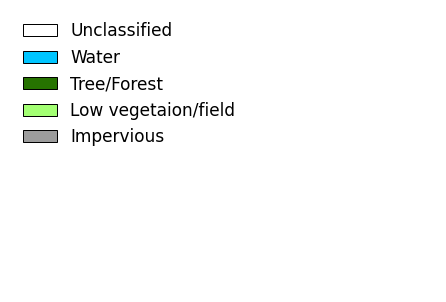

In [13]:
lc.make_legend_figure('chesapeake_4')

# gather highres labels, LC predictions, naip, and prior

In [14]:
ea_data_dir = '/torchgeo_data/enviroatlas_lotp'

In [20]:
import pickle
LCTileIndex.TILES = pickle.load(open("../../landcover/data/tile_index/lc2019/tiles.p", "rb"))

In [31]:
this_state_dir = f'{ea_data_dir}/{state}-test_tiles-debuffered'


In [32]:
hr_fns

['3507801_se_a_naip.tif',
 '3507801_sw_a_naip.tif',
 '3607857_sw_a_naip.tif',
 '3607857_ne_a_naip.tif',
 '3507801_nw_a_naip.tif',
 '3607858_sw_a_naip.tif',
 '3507801_ne_a_naip.tif',
 '3607857_se_a_naip.tif',
 '3507802_nw_a_naip.tif',
 '3507908_se_a_naip.tif']

In [33]:
from web_tool.DataLoader import LCTileIndex, LC_BLOB_ROOT

def lc_layer_fn_from_local(fn_img_to_match):
    print(fn_img_to_match)
    with rasterio.open(fn_img_to_match) as f:
        bounds_new = rasterio.warp.transform_bounds(f.profile['crs'], 'epsg:4326', *f.bounds)

        # use the middle 1/2 of the image for the query because it won't perfectly overlap
        del_x, del_y = (bounds_new[2] - bounds_new[0]) / 4, (bounds_new[3] - bounds_new[1]) / 4
        bounds_half = np.array(bounds_new) + np.array([del_x, del_y, - del_x, -del_y])
        xy = np.array(shapely.geometry.box(*bounds_half).exterior.xy).T[np.newaxis,...]

        poly = {"type":"Polygon", "coordinates": xy}

    return os.path.join(LC_BLOB_ROOT, LCTileIndex.lookup(poly))


def lc_layer_fn_match_img_extent(fn_img_to_match):
    f_found = lc_layer_fn_from_local(fn_img_to_match)
    with rasterio.open(fn_img_to_match) as f:
        cc_bounds = f.bounds
    with rasterio.open(f_found) as f:
        f_cropped, _ = rasterio.mask.mask(f, [shapely.geometry.mapping(shapely.geometry.box(*cc_bounds))], crop=True)
    return f_cropped


def aggregate_results(state, ea_to_cc_map,n_classes, reassign_impervious_to_barren=False):
    
    accs = []
    ious = []
    num_pix =[]

    this_state_dir = f'{ea_data_dir}/{state}-test_tiles-debuffered'
    hr_fns = [x for x in os.listdir(this_state_dir) if 'naip' in x]
    tile_ids = [x[:10] for x in hr_fns]

    for i,tile_id in enumerate(tile_ids):
        print(i, tile_id)
        fn_this = os.path.join(this_state_dir, tile_id + '_h_highres_labels.tif')

        # gather the data
        with rasterio.open(fn_this) as f:
            ea_lc = lc.map_raw_lc_to_idx['enviroatlas'][f.read()[0]]

        preds_2019_lc = lc_layer_fn_match_img_extent(fn_this).argmax(0)

        # realign the classes - lc uses just for classes for this task
        ea_lc_reformatted = ea_to_cc_map[ea_lc]
        
        if reassign_impervious_to_barren:
            assert n_classes == 5
            # match the 5 class definition given below
            impervious_idx = 3
            barren_idx = 4
            predicted_impervious_but_actually_barren = np.logical_and(preds_2019_lc == impervious_idx,
                                                                      ea_lc_reformatted == barren_idx)
            
            preds_2019_lc[predicted_impervious_but_actually_barren] = barren_idx

        acc_this = (preds_2019_lc == ea_lc_reformatted)[ea_lc_reformatted != nodata_idx].mean()
        num_pix.append(np.sum([ea_lc_reformatted != nodata_idx]))
        # ignore 0
        iou_this = util.per_class_iou(ea_lc_reformatted, preds_2019_lc, np.arange(0, n_classes))
        accs.append(acc_this)
        ious.append(iou_this)

    return ious, accs, num_pix

# 1. merge barren and impervious

In [34]:
nodata_idx = 7
ea_to_cc_remap_merge_barren = {
    0: nodata_idx, # no data
    1: 0, # water
    2: 3, # impervious
    3: 3, # soil/barren
    4: 1,  # trees
    5: nodata_idx,  # for now call shrub tree - but ignore shrubs. the co
    6: 2, # low vegetation/field
}

ea_to_cc_merge_barren_and_impervious =np.zeros(np.array(list(ea_to_cc_remap_merge_barren.keys())).max() + 1, dtype=np.uint8)
for i, k in enumerate(ea_to_cc_remap_merge_barren):
    ea_to_cc_merge_barren_and_impervious[k] = ea_to_cc_remap_merge_barren[k]
    
    
results_by_state_merge_barren_and_impervious = {}
for state in [
    'phoenix_az-2010_1m',
    'durham_nc-2012_1m',
    'austin_tx-2012_1m',
    'pittsburgh_pa-2010_1m'
]:
    ious, accs, num_pix = aggregate_results(state, ea_to_cc_merge_barren_and_impervious,n_classes=4)

    results_by_state_merge_barren_and_impervious[state] = {'ious':ious, 'accs': accs, 'num_pix':num_pix}
    
    print('for state ',state)
    ious_aggregated = util.aggregate_ious([x[1] for x in ious], [x[2] for x in ious])

    print(f'mean IoU: {np.mean(ious_aggregated[0])}')
    acc_aggregated = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
    print(f'acc: {acc_aggregated}')

    print('IoU per class over the tiles is: ')
    print(ious_aggregated[0])


0 3311215_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311215_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311215_sw_12_1_20100608_probs.tif
1 3311224_ne
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311224_ne_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311224_ne_12_1_20100608_probs.tif
2 3311117_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311117_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33111/m_3311117_sw_12_1_20100608_probs.tif
3 3311228_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311228

1 4008048_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4008048_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40080/m_4008048_nw_17_1_20100618_probs.tif
2 4007933_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007933_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007933_nw_17_1_20100618_probs.tif
3 4007926_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007926_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007926_sw_17_1_20100608_probs.tif
4 4007925_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007925_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/400

# 2. penalize 2019 map for not predicting barren

In [36]:
nodata_idx = 7
ea_to_cc_remap_with_barren = {
    0: nodata_idx, # no data
    1: 0, # water
    2: 3, # impervious
    3: 4, # soil/barren as a 5th index
    4: 1,  # trees
    5: nodata_idx,  # for now call shrub tree - but ignore shrubs. the co
    6: 2, # low vegetation/field
}

ea_to_cc_with_barren =np.zeros(np.array(list(ea_to_cc_remap_with_barren.keys())).max() + 1, dtype=np.uint8)
for i, k in enumerate(ea_to_cc_remap_with_barren):
    ea_to_cc_with_barren[k] = ea_to_cc_remap_with_barren[k]
    
    
results_by_state_with_barren = {}
for state in [
    'phoenix_az-2010_1m',
    'durham_nc-2012_1m',
    'austin_tx-2012_1m',
    'pittsburgh_pa-2010_1m'
]:
    ious, accs, num_pix = aggregate_results(state, ea_to_cc_with_barren, n_classes = 5)
    results_by_state_with_barren[state] = {'ious':ious, 'accs': accs, 'num_pix':num_pix}
    
    print('for state ',state)
    ious_aggregated = util.aggregate_ious([x[1] for x in ious], [x[2] for x in ious])
    print(f'mean IoU: {np.mean(ious_aggregated[0])}')
    acc_aggregated = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
    print(f'acc: {acc_aggregated}')

    print('IoU per class over the tiles is: ')
    print(ious_aggregated[0])

0 3311215_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311215_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311215_sw_12_1_20100608_probs.tif
1 3311224_ne
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311224_ne_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311224_ne_12_1_20100608_probs.tif
2 3311117_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311117_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33111/m_3311117_sw_12_1_20100608_probs.tif
3 3311228_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311228

/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4008048_ne_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40080/m_4008048_ne_17_1_20100618_probs.tif
1 4008048_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4008048_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40080/m_4008048_nw_17_1_20100618_probs.tif
2 4007933_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007933_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007933_nw_17_1_20100618_probs.tif
3 4007926_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007926_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007926_

# 3. anywhere 2019 predicts impervious but the label is barren, give 2019 benefit of the doubt

In [37]:
results_by_state_reassinging_impervious_tobarren = {}
for state in [
    'phoenix_az-2010_1m',
    'durham_nc-2012_1m',
    'austin_tx-2012_1m',
    'pittsburgh_pa-2010_1m'
]:
    ious, accs, num_pix = aggregate_results(state, 
                                            ea_to_cc_with_barren, 
                                            n_classes = 5, 
                                            reassign_impervious_to_barren= True)
    
    results_by_state_reassinging_impervious_tobarren[state] = {'ious':ious, 'accs': accs, 'num_pix':num_pix}
    
    print('for state ',state)
    ious_aggregated = util.aggregate_ious([x[1] for x in ious], [x[2] for x in ious])
    print(f'mean IoU: {np.mean(ious_aggregated[0])}')
    acc_aggregated = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
    print(f'acc: {acc_aggregated}')

    print('IoU per class over the tiles is: ')
    print(ious_aggregated[0])

0 3311215_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311215_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311215_sw_12_1_20100608_probs.tif
1 3311224_ne
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311224_ne_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311224_ne_12_1_20100608_probs.tif
2 3311117_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311117_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33111/m_3311117_sw_12_1_20100608_probs.tif
3 3311228_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/az/az_1m_2010/33112/m_3311228

1 4008048_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4008048_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40080/m_4008048_nw_17_1_20100618_probs.tif
2 4007933_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007933_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007933_nw_17_1_20100618_probs.tif
3 4007926_sw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007926_sw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/40079/m_4007926_sw_17_1_20100608_probs.tif
4 4007925_nw
/datadrive/esther/torchgeo_data/enviroatlas_lotp/pittsburgh_pa-2010_1m-test_tiles-debuffered/4007925_nw_h_highres_labels.tif
Found 1 intersections, returning at 1_3_2019/data/v1/2010/states/pa/pa_1m_2010/400

# print results alltogether

In [49]:
def print_results_string(results_by_state, states = [
    'pittsburgh_pa-2010_1m',
    'durham_nc-2012_1m',
    'austin_tx-2012_1m',
    'phoenix_az-2010_1m',
    ]):

    print_str = ''

    for state in states:
        results_this = results_by_state[state]
        ious, accs, num_pix = results_this['ious'], results_this['accs'], results_this['num_pix']
        ious_aggregated = util.aggregate_ious([x[1] for x in ious], [x[2] for x in ious])
        acc_aggregated = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
        
        acc_avg = (np.array(accs) * np.array(num_pix)).sum() / np.sum(num_pix)
        ious_avg = np.mean(ious_aggregated[0])
        print_str += f'& {np.round(acc_avg*100,1):.01f} '
        print_str += f'& {np.round(ious_avg*100,1):.01f} '
        
    print(print_str)

In [50]:
print_results_string(results_by_state_merge_barren_and_impervious)

& 79.0 & 68.7 & 77.0 & 54.1 & 76.5 & 60.4 & 24.7 & 16.8 


In [51]:
print_results_string(results_by_state_with_barren)

& 78.8 & 55.1 & 76.6 & 43.4 & 76.2 & 49.1 & 18.2 & 18.8 


In [52]:
print_results_string(results_by_state_reassinging_impervious_tobarren)

& 79.0 & 61.5 & 77.0 & 49.6 & 76.5 & 51.8 & 24.7 & 23.6 
